# reaction-network (Demo Notebook, v2)
### Author: Matthew McDermott
### Date: January 28, 2021

The following notebook serves as a walkthrough for the use of the *reaction-network* code, which is imported as *rxn_network*. 

In the following examples, we recreate the results/analysis originally presented in the manuscript: 

*Matthew J. McDermott, Shyam Dwaraknath, and Kristin A. Persson. “A graph-based network for predicting chemical reaction pathways in solid-state materials synthesis” (2021)*.


## Imports
The following imports are required to access the Materials Project database and construct the network.  Don't worry if you see an error regarding the cairo package for drawing the networks; this part is optional.

In [1]:
import logging
import pickle
import json
import numpy as np
import itertools
from datetime import date

from monty.json import MontyDecoder

import graph_tool.all as gt

from rxn_network.core import ReactionNetwork
from rxn_network.entries import CustomEntry, GibbsComputedStructureEntry
from rxn_network.helpers import find_interdependent_rxns
from rxn_network.reaction import Reaction, ComputedReaction

from pymatgen import MPRester, Structure, Element, Composition
from pymatgen.analysis.phase_diagram import PhaseDiagram

logging.info("Logging initialized")
%load_ext autoreload
%autoreload 2


Note: this code uses Dask to parallelize the building of the reaction network graph. The client is initialized below, and the Dask web GUI can be accessed via a local HTTP server (see Dask documentation for further details).

In [2]:
from dask.distributed import Client
client = Client()
logging.info("Logging initialized")
print("Client initialized...")

/Users/mcdermott/miniconda3/envs/gt/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57686 instead
  warnings.warn(


Client initialized...


## Main script
The following function's code can be run as a standalone script to generate the reaction network and perform pathfinding. In the first example that follows, we will break down each of these steps so it is clear what each section of the script is doing. In the following sections, we will only povide the input parameters and refer you to running the main script yourself.

In [3]:
def reaction_network_analysis(entries, precursors, targets, temp, include_metastable, k, chempots, max_num_combos, interpolate_comps=[]):
    rn = ReactionNetwork(entries, temp=temp, interpolate_comps=interpolate_comps, 
                         include_metastable=include_metastable)

    precursors_comps = [Composition(s) for s in precursors]
    targets_comps = [Composition(t) for t in targets]

    precursor_entries = []
    target_entries = []

    for entry in rn._filtered_entries:
        if entry.composition.reduced_composition in precursors_comps:
            precursor_entries.append(entry)
        elif entry.composition.reduced_composition in targets_comps:
            target_entries.append(entry)

    rn.generate_rxn_network(precursor_entries,target_entries)
    paths = rn.find_all_rxn_pathways(k=k, precursors=precursor_entries, consider_crossover_rxns=True, 
                                         max_num_combos=max_num_combos, filter_interdependent=False,
                                        chempots=chempots)
    return rn, paths

# Example 1: YMnO$_3$ assisted metathesis

## Building the phase diagram entries

First, we acquire Materials Project entries for the C-Cl-Li-Mn-O-Y chemical system via the MPRester API; please see materialsproject.org to create an account and get an API key.

Note: *You may also use your own thermodynamic database entries, but they must be initialized as ComputedStructureEntry objects in pymatgen*.

In [4]:
chemsys = "C-Cl-Li-Mn-O-Y"
with MPRester() as mpr:  # requires API key from Materials Project
    all_entries = mpr.get_entries_in_chemsys(chemsys, inc_structure="final") 

/Users/mcdermott/PycharmProjects/pymatgen/pymatgen/ext/matproj.py:581: FutureWarning: __init__ is deprecated
MaterialsProjectCompatibility will be updated with new correction classes as well as new values of corrections and uncertainties in 2020
  entries = MaterialsProjectCompatibility().process_entries(entries)


Let's first see how many of these entries are stable at T = 0 K by constructing a compositional phase diagram:

In [5]:
pd_mp = PhaseDiagram(all_entries)
print(pd_mp)

Li-Y-Mn-C-Cl-O phase diagram
53 stable phases: 
CCl4, ClO2, Y2O3, Li, Li2MnO3, LiCl, MnO2, Cl2, YMn12, Mn, Y10Mn13C18, Cl2O7, MnO, Y2C, Li11Mn13O32, Li6MnO4, Li2CO3, Y4C7, Mn8Cl3O10, Cl2O, ClO3, CO2, Mn3O4, Li2O2, Mn2O3, YClO, Y2Mn2O7, LiO8, LiMnO2, LiMn(CO3)2, LiYO2, Y3C4, Y4C5, Mn7C3, Mn23C6, LiC12, LiMn2O4, Li2O, Li9Mn20O40, C, LiClO4, YCCl, Y2Cl3, MnCl2, Y, YMn2O5, Li9Mn14O32, YMnO3, MnCO3, Y(ClO4)3, O2, YCl3, Li4Mn5O12


When we initialize the network in the next section, it will attempt to estimate the finite temperature phase diagram via a Gibbs estimation model, such as the SISSO model from Bartel et al. Let's see what that does to the phase diagram at T = 900 K:

In [6]:
gibbs_entries = GibbsComputedStructureEntry.from_pd(pd_mp, temp=900)
pd_gibbs = PhaseDiagram(gibbs_entries)
print(pd_gibbs)

Li-Y-Mn-C-Cl-O phase diagram
38 stable phases: 
O2, Li2MnCO4, MnO2, LiMn2O4, CCl2O, MnO, Li2CO3, Li4Mn5O12, Mn, Li2O, Mn2O3, Y4C5, Y10Mn13C18, Y2Mn2O7, YMnO3, CO2, YMn2O5, Li, Mn3O4, YClO, MnCO3, YMn12, Y2C, YCCl, LiMnO2, CCl3, C, Y2O3, MnCl2, Cl2, Y4C7, Li2Mn(CO3)2, YCl3, Mn8Cl3O10, Y, LiC12, LiCl, Li2MnO3


It appears that many structures are destabilized at high temperature according to the Gibbs SISSO descriptor. This will affect how we filter entries to include in the network.

## Creating the reaction network

To create the reaction network, we must first initialize a ReactionNetwork object with a list of ComputedStructureEntry objects (at T = 0 K). This performs necessary preprocessing steps on the list of entries, such as converting them to *GibbsComputedStructureEntry* objects and filtering for thermodynamic stability. Please see the code documentation for more description on the input parameters. In the example below, we will be using a thermodynamic stability cutoff of +30 meV/atom above hull.

In [7]:
rn = ReactionNetwork(all_entries, n=2, temp=900, include_metastable=0.0) # include entries <= 30 meV/atom above hull

INFO:ReactionNetwork:Initializing network with 38 entries: 
O2, Li2CO3, Li2MnCO4, Li2O, MnO2, LiMn2O4, CCl2O, MnO, Li4Mn5O12, Mn, Mn2O3, Y4C5, Y10Mn13C18, Y2Mn2O7, YMnO3, CO2, YMn2O5, Li, Mn3O4, YClO, MnCO3, YMn12, Y2C, LiCl, YCCl, LiMnO2, CCl3, C, Y2O3, MnCl2, Cl2, Li2Mn(CO3)2, Y4C7, YCl3, Mn8Cl3O10, Y, LiC12, Li2MnO3


To actually create the reaction network graph, we must specify both a list of precursor entries and list of target entries. Either (or both) of these can also be empty; if so, the network will treat these precursor/target nodes as "dummy" nodes, meaning that they will link into/out of every node in the network.

The assisted metathesis reaction reported by Todd & Neilson (2019) we would like to study is the following:

$$ Mn_2O_3 + 2 YCl_3 + 3Li_2CO_3 -> 2YMnO_3 + 6LiCl + 3CO_2 $$

We first identify the compositions of this reaction and verify that it is correct by having it automatically balanced:

In [8]:
precursors = ["Mn2O3", "YCl3","Li2CO3"]
targets = ["YMnO3","CO2","LiCl"]

precursors = [Composition(s) for s in precursors]
targets = [Composition(t) for t in targets]

net_rxn = Reaction(precursors,targets)
print(f"Net RXN: {net_rxn}")

Net RXN: 0.5 Mn2O3 + YCl3 + 1.5 Li2CO3 -> YMnO3 + 1.5 CO2 + 3 LiCl


We then need to select which entries correspond to the precursors and targets. If we only know the compositions we want, we need to iterate through all of the entries to find them:

In [9]:
precursor_entries = []
target_entries = []

for entry in rn._filtered_entries:
    if entry.composition.reduced_composition in precursors:
        precursor_entries.append(entry)
    elif entry.composition.reduced_composition in targets:
        target_entries.append(entry)

Finally, we generate the reaction network itself. This process iterates through all possible chemical reactions and creates weighted edges using the designated cost function. 

**IMPORTANT NOTE: this particular graph will likely take 5-10 minutes to generate, depending on your CPU specs.** The progress of the calculation can be checked via the Dask GUI. We strongly recommend you use computing resources for performing these calculations, if available to you.

In [10]:
rn.generate_rxn_network(precursor_entries,target_entries,"softplus")

INFO:ReactionNetwork:Generating reactions by chemical subsystem...
INFO:ReactionNetwork:Graph creation took 19.3 seconds.
INFO:ReactionNetwork:Created graph with 1485 nodes and 7595 edges.


## Finding shortest pathways

Now that the graphi s constructed, we can look for shortest paths on the graph to a specific target. For example, we can look at the shortest paths from the precursors to YMnO$_3$ alone.

In [11]:
ymno3_entry = [t for t in target_entries if t.composition.reduced_formula == "YMnO3"][0]
rn.set_target(ymno3_entry)

paths = rn.find_k_shortest_paths(10)

9 Mn2O3 + 2 YCl3 -> Y2Mn2O7 + 2 Mn8Cl3O10 (dG = -0.015 eV/atom) 
0.5 Y2Mn2O7 + 0.5 Mn2O3 -> MnO2 + YMnO3 (dG = 0.018 eV/atom) 
Total Cost: 0.531 

5 Mn2O3 + YCl3 -> YMn2O5 + Mn8Cl3O10 (dG = -0.025 eV/atom) 
YMn2O5 -> MnO2 + YMnO3 (dG = 0.061 eV/atom) 
Total Cost: 0.539 

9 Mn2O3 + 2 YCl3 -> Y2Mn2O7 + 2 Mn8Cl3O10 (dG = -0.015 eV/atom) 
2 Y2Mn2O7 -> O2 + 4 YMnO3 (dG = 0.058 eV/atom) 
Total Cost: 0.54 

Mn2O3 + Li2CO3 -> Li2MnO3 + MnCO3 (dG = -0.026 eV/atom) 
YCl3 + MnCO3 -> CCl3 + YMnO3 (dG = 0.404 eV/atom) 
Total Cost: 0.634 

Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
0.5 Mn2O3 + 0.5 Y2O3 -> YMnO3 (dG = -0.048 eV/atom) 
Total Cost: 0.756 

Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
0.5 Mn2O3 + 1.5 Y2O3 -> YMnO3 + Y2O3 (dG = -0.024 eV/atom) 
Total Cost: 0.761 

Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG =

While this is nice for understanding which reaction(s) lead to YMnO$_3$, this pathway identification contains no enformcent of conservation of mass. Since we know the stoichiometric coefficients of the **net** reaction, we need to combine these shortest paths in a logical way.

Thus net reaction pathways are identified by finding the k shortest paths to each target, and then attempting to combine identified reactions to form a set that satisifies the stoichiometry of the net reaction. 

You will see in the output below: 1) the k-shortest paths to each target, 2) a step showing the progress of identification of crossover reactions, and 3) a printed list of all reactions being considered during postprocessing.

**IMPORTANT NOTE: the k-shortest paths algorithm (Yen's algorithm) typically performs very quickly, but the postprocessing of combinations can take some time to generate and balance combinations. Even though it is parallelized, this step may take 10-20 mins depending on your computing specs.** We again strongly recommend the use of computing resources for this task.

In [14]:
k = 20
max_num_combos = 4
chempots = {Element("O"):0}

paths = rn.find_all_rxn_pathways(k=k, precursors=precursor_entries, targets=target_entries,
                                 consider_crossover_rxns=True, max_num_combos=max_num_combos, 
                                 filter_interdependent=False, chempots=chempots)

INFO:ReactionNetwork:NET RXN: 0.1667 Mn2O3 + 0.5 Li2CO3 + 0.3333 YCl3 -> LiCl + 0.5 CO2 + 0.3333 YMnO3 



PATHS to LiCl 

--------------------------------------- 

Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
Total Cost: 0.502 

Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
Li2O + YCl3 -> YClO + 2 LiCl (dG = -0.281 eV/atom) 
Total Cost: 0.507 

Mn2O3 + 2 Li2CO3 -> Li2Mn(CO3)2 + Li2MnO3 (dG = -0.061 eV/atom) 
Mn2O3 + 2 Li2MnO3 -> Li2O + 2 LiMn2O4 (dG = 0.053 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
Total Cost: 0.73 

Mn2O3 + Li2CO3 -> MnO2 + Li2MnCO4 (dG = 0.022 eV/atom) 
Li2CO3 + Li2MnCO4 -> Li2O + Li2Mn(CO3)2 (dG = -0.013 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
Total Cost: 0.733 

Mn2O3 + 2 Li2CO3 -> Li2Mn(CO3)2 + Li2MnO3 (dG = -0.061 eV/atom) 
Mn2O3 + 2 Li2MnO3 -> Li2O + 2 LiMn2O4 (dG = 0.053 eV/atom) 
Li2O + YCl3 -> YClO + 2 LiCl (dG = -0.281 eV/atom) 
Total Cost: 0.735 

Mn2O3 + Li2CO3 -> Li2MnO3 + MnCO3 (dG = -0.026 eV/atom) 
Mn2O3 + 2 Li2MnO3 -> Li

  2%|▏         | 6/276 [00:00<00:06, 43.04it/s]

9 Mn2O3 + 2 YCl3 -> Y2Mn2O7 + 2 Mn8Cl3O10 (dG = -0.015 eV/atom) 
0.5 Y2Mn2O7 + 0.5 Mn2O3 -> MnO2 + YMnO3 (dG = 0.018 eV/atom) 
Total Cost: 0.531 

5 Mn2O3 + YCl3 -> YMn2O5 + Mn8Cl3O10 (dG = -0.025 eV/atom) 
YMn2O5 -> MnO2 + YMnO3 (dG = 0.061 eV/atom) 
Total Cost: 0.539 

9 Mn2O3 + 2 YCl3 -> Y2Mn2O7 + 2 Mn8Cl3O10 (dG = -0.015 eV/atom) 
2 Y2Mn2O7 -> O2 + 4 YMnO3 (dG = 0.058 eV/atom) 
Total Cost: 0.54 

Mn2O3 + Li2CO3 -> Li2MnO3 + MnCO3 (dG = -0.026 eV/atom) 
YCl3 + MnCO3 -> CCl3 + YMnO3 (dG = 0.404 eV/atom) 
Total Cost: 0.634 

Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
0.5 Mn2O3 + 0.5 Y2O3 -> YMnO3 (dG = -0.048 eV/atom) 
Total Cost: 0.756 

Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
0.5 Mn2O3 + 1.5 Y2O3 -> YMnO3 + Y2O3 (dG = -0.024 eV/atom) 
Total Cost: 0.761 

Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG =

100%|██████████| 276/276 [00:18<00:00, 15.21it/s]
INFO:ReactionNetwork:Considering 60 reactions...
0it [00:00, ?it/s]

[Li2CO3 -> Li2O + CO2,
 0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3,
 Li2O + YCl3 -> YClO + 2 LiCl,
 Mn2O3 + 2 Li2CO3 -> Li2Mn(CO3)2 + Li2MnO3,
 Mn2O3 + 2 Li2MnO3 -> Li2O + 2 LiMn2O4,
 Mn2O3 + Li2CO3 -> MnO2 + Li2MnCO4,
 Li2CO3 + Li2MnCO4 -> Li2O + Li2Mn(CO3)2,
 Mn2O3 + Li2CO3 -> Li2MnO3 + MnCO3,
 0.5 Mn2O3 + 0.5 Li2CO3 -> LiMnO2 + 0.5 CO2,
 2 Mn2O3 + 4 Li2CO3 -> O2 + 4 Li2MnCO4,
 1.667 Li2MnO3 -> Li2O + 0.3333 Li4Mn5O12,
 Mn2O3 -> MnO + MnO2,
 MnO + 2 Li2CO3 -> Li2O + Li2Mn(CO3)2,
 0.5 O2 + Li2MnCO4 -> CO2 + Li2MnO3,
 1.5 MnO2 + 0.5 Li2MnCO4 -> LiMn2O4 + 0.5 CO2,
 2 Mn2O3 -> MnO2 + Mn3O4,
 MnO2 + Li2CO3 -> CO2 + Li2MnO3,
 Mn2O3 + MnCO3 -> CO2 + Mn3O4,
 2.5 MnO2 + Li2CO3 -> CO2 + 0.5 Li4Mn5O12,
 Li2CO3 + MnCO3 -> CO2 + Li2MnCO4,
 0.5 MnO2 + 0.5 Li2MnCO4 -> LiMnO2 + 0.5 CO2,
 Li2Mn(CO3)2 -> CO2 + Li2MnCO4,
 MnCO3 -> MnO + CO2,
 2 Mn2O3 -> Mn + 3 MnO2,
 9 Mn2O3 + 2 YCl3 -> Y2Mn2O7 + 2 Mn8Cl3O10,
 0.5 Y2Mn2O7 + 0.5 Mn2O3 -> MnO2 + YMnO3,
 5 Mn2O3 + YCl3 -> YMn2O5 + Mn8Cl3O10,
 YMn2O5 -> 

1it [00:02,  2.91s/it]
1it [00:00, 34.35it/s]
1it [00:00,  3.52it/s]
INFO:ReactionNetwork:Generating and filtering size 4 pathways...
1it [00:04,  4.54s/it]


Let's check out the results. We should see several balanced pathways stored in the **paths** list object.

In [17]:
for num, path in enumerate(paths):
    print(f"Path {num+1}:")
    print(path)

Path 1:
Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
0.5 Mn2O3 + 0.5 Y2O3 -> YMnO3 (dG = -0.048 eV/atom) 

Total Cost: 0.238 | Average Cost: 0.079


Path 2:
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
Li2CO3 + Li2MnCO4 -> Li2O + Li2Mn(CO3)2 (dG = -0.013 eV/atom) 
Li2Mn(CO3)2 -> Li2MnCO4 + CO2 (dG = 0.096 eV/atom) 
0.5 Mn2O3 + 0.5 Y2O3 -> YMnO3 (dG = -0.048 eV/atom) 

Total Cost: 0.24 | Average Cost: 0.06


Path 3:
0.5 Mn2O3 + 0.5 Y2O3 -> YMnO3 (dG = -0.048 eV/atom) 
Li2CO3 + YCl3 -> CO2 + YClO + 2 LiCl (dG = -0.11 eV/atom) 
Li2CO3 + 2 YClO -> CO2 + 2 LiCl + Y2O3 (dG = -0.034 eV/atom) 

Total Cost: 0.248 | Average Cost: 0.083


Path 4:
Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Mn2O3 + 0.5 Y2O3 -> YMnO3 (dG = -0.048 eV/atom) 
Li2CO3 + YCl3 -> CO2 + YClO + 2 LiCl (dG = -0.11 eV/atom) 
0.5 Li2O + YClO -> LiCl + 0.5 Y2O3 (dG = -0.142 eV/atom) 

Total Cost: 0.249 | Average Cost: 0.062


Path 5:
Li2

## Plotting the network

There are many, many methods for plotting large graphs. One of the more useful approaches is to use an interactive interface such as the one provided by **Graphistry Hub**, which was also used to create the illustations in the paper. 

If you wish to use Graphistry Hub, you may sign up for an account and use their Python API (pygraphistry).

Another option is to use the built-in drawing in graph-tool, atlhough it is often more difficult to get insightful results. For example, this might look like the following, where we generate and then draw a filtered graph where zero-weight edges have been removed. This essentially just shows the "sub-networks" of chemical reactions broken down by smaller systems within the bigger chemical system. These sub-networks are connceted to each other via the zero-weight edges.

In [18]:
rn.g.ep["zero_cost"] = rn.g.new_edge_property("bool")
for s,t,weight in rn.g.iter_edges(eprops=[rn.g.ep["weight"]]):
    rn.g.ep["zero_cost"][rn.g.edge(s,t)] = (weight!=0)
    
filtered_graph = gt.GraphView(rn.g, efilt=rn.g.ep.zero_cost)

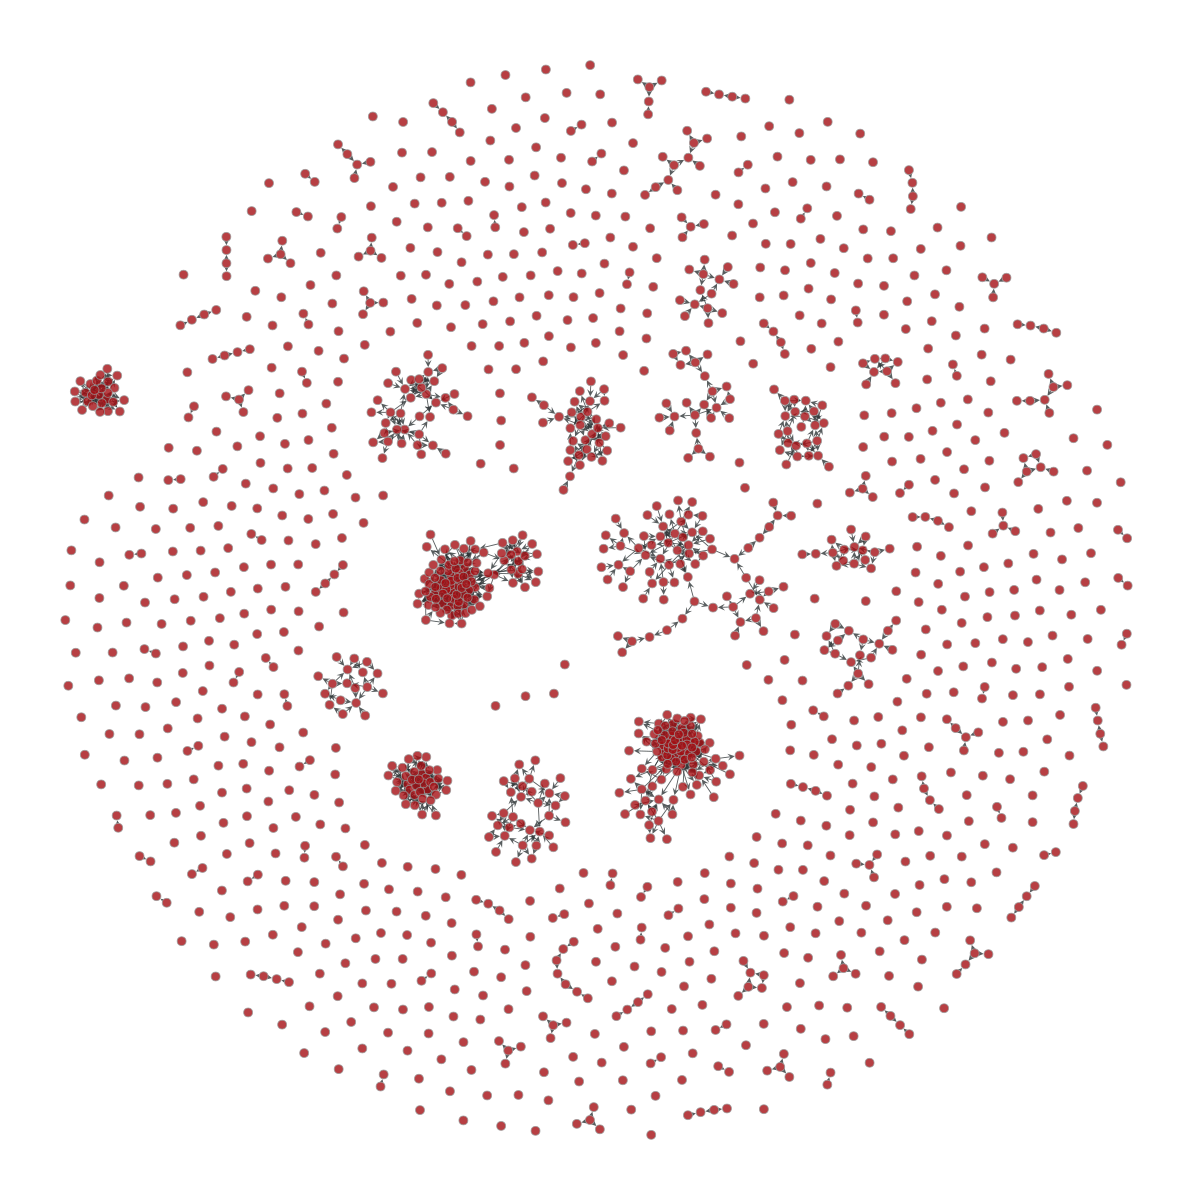

In [19]:
gt.graph_draw(filtered_graph);

There are many more insightful plots (e.g. histograms) you can make simply by using the built-in property maps of the graph-tool object. For example, you can plot the relative counts of the different sub-chemical systems represented in the graph (requires seaborn):

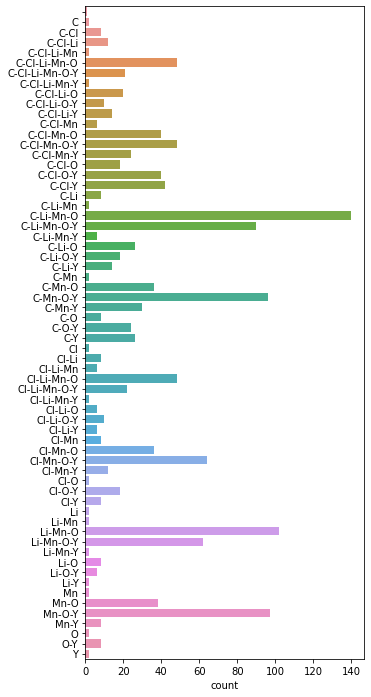

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(5,12))
sns.countplot(y=sorted(list(rn.g.vp["chemsys"])),orient="v");

# Example 2: Y$_2$Mn$_2$O$_7$ assisted metathesis

Now that we have shown step-by-step how the process works for the YMnO$_3$ system, we will now only provide the parameters used to construct the network, and load/analyze the results discussed in the paper.

In [ ]:
temp = 900
include_metastable = 0.03
k=20
chempots={Element("O"):0}
max_num_combos=5

# Example 3: Fe$_2$SiS$_4$ synthesis from iron silicide precursors

# Example 4: YBCO synthesis from barium peroxide